<a href="https://colab.research.google.com/github/simonwardjones/d2l-study-group/blob/master/exercises/assignment-7-sw-j.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 7 - assignment

>Simon Ward-Jones - November 2020

**Steps**

---
    1. Connect to kaggle via api and download data
        a. Read kaggle api tokens from google drive
        b. Download data using kaggle package
    2. Explore data and prepare PyToch dataset and dataloader
    3. Create net - explaining architecture
    4. Train
    5. Make prediction and print accuracy



## Connect to kaggle via api and download data

In [1]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

In [3]:
auth.authenticate_user()

In [4]:
# get kaggle key from google drive
drive_service = build('drive', 'v3')
results = drive_service.files().list(q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])


In [5]:
# save kaggle json to default location on google colab machine
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
if int(status.progress()) == 1:
    print("Downloaded kaggle.json")
os.chmod(filename, 600)

Downloaded kaggle.json


In [6]:
# Install kaggle packages
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 5.3MB 20.0MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
     |████████████████████████████████| 112kB 41.4MB/s 
     |████████████████████████████████| 133kB 41.0MB/s 


In [7]:
# Download the dataset using kaggle api
!kaggle datasets download -d ashishsaxena2209/animal-image-datasetdog-cat-and-panda

 98% 369M/376M [00:11<00:00, 22.4MB/s]
100% 376M/376M [00:11<00:00, 32.9MB/s]


In [40]:
# Extract the folder (-o overwrite, -q quiet) to current dir
!unzip -oq animal-image-datasetdog-cat-and-panda.zip

In [76]:
ls animals/animals

cats/  dogs/  panda/


## Explore data and prepare PyToch dataset and dataloader

In [142]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, datasets

from sklearn.model_selection import train_test_split
from IPython.display import display

In [166]:
# Load the dataset using the torchvision imagefolder dataset
# datasets.ImageFolder??
resize = (256, 256)
cats_dogs_pandas = datasets.ImageFolder(
    root='./animals/animals',
    transform=transforms.Resize(resize))

In [167]:
cats_dogs_pandas.class_to_idx # map labels to integers
# cats_dogs_pandas.imgs[:3] # image paths and labels

{'cats': 0, 'dogs': 1, 'panda': 2}

Displaying image 0 with label 0:


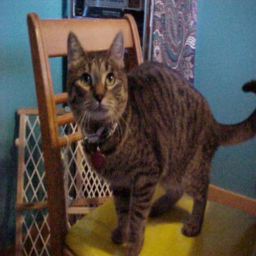

Displaying image 1000 with label 1:


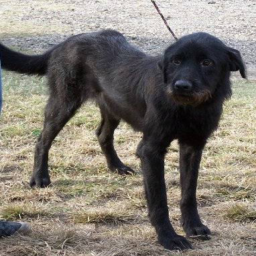

Displaying image 2000 with label 2:


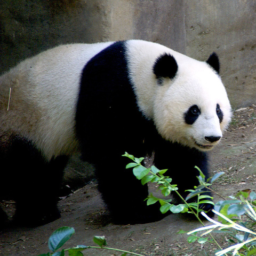

In [168]:

for i in range(3):
    idx = i * 1000
    print(f'Displaying image {idx} with label {cats_dogs_pandas[idx][1]}:')
    display(cats_dogs_pandas[idx][0])

## Train test split

We want to acheive a stratified split

In [169]:
train_idx, test_idx= train_test_split(
    torch.arange(len(cats_dogs_pandas.targets)),
    test_size=0.2,
    shuffle=True,
    stratify=cats_dogs_pandas.targets)

In [170]:
targets = torch.Tensor(cats_dogs_pandas.targets) 

In [171]:
# Show targets are balanced:
for label in [0, 1, 2]:
  print(
      f'There are {(targets[train_idx] == label).sum()}'
      f' {label}\'s in the training data')


There are 800 0's in the training data
There are 800 1's in the training data
There are 800 2's in the training data


In [174]:
batch_size = 64

# Now load the data into train/test with transforms
data_transform = transforms.Compose([
    transforms.Resize(resize),
    transforms.ToTensor()
])

cats_dogs_pandas = datasets.ImageFolder(
    root='./animals/animals',
    transform=data_transform)

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
train_loader = DataLoader(
    dataset=cats_dogs_pandas,
    batch_size=batch_size,
    sampler=train_sampler)
test_loader = DataLoader(
    dataset=cats_dogs_pandas,
    batch_size=batch_size,
    sampler=test_sampler)